Using the Credit Card Fraud Detection dataset from kaggle
to train a pyspark Logistic Regression Model, logging in it to MLFlow.

Data corresponds to anonymized credit card transactions labeled as fraudulent or genuine.

Available at
www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import pyspark #
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F

import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

from IPython.display import Image, display, Markdown     
from IPython.core.display import HTML                    
#Display the dataframe in table format
display(HTML("<style = fonte-size>pre { white-space: pre !important; }</style>"))

CPU times: user 3.49 s, sys: 408 ms, total: 3.9 s
Wall time: 10.8 s


# Creating a spark session

In [2]:
%%time
os.environ["SPARK_LOCAL_IP"]='127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
conf = spark.sparkContext._conf.getAll()

23/04/16 00:21:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


CPU times: user 40.7 ms, sys: 34.6 ms, total: 75.3 ms
Wall time: 6.9 s


# Loading the dataset

In [3]:
%%time
data_path = 'creditcard.csv'
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)
df.show(5)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


23/04/16 00:21:40 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

# Getting columns' description

In [4]:
%%time
print(df.count())
df.summary().show()

284807


+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|  

# Splitting dataframe by Class and Selecting columns for the 'features' vector

In [5]:
%%time
#inputs to the assembler, columns to transform into the features vector.
dfFeatures = df.select(F.col(labelColumn).alias('label'),*numericCols )
dfFeatures.show(3)

normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")

#80-20 split between the training and testing data
normal_train, normal_test = normal.randomSplit([0.8, 0.2],seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2],seed = 2020)

#Combining normal and anomaly splits to form the training and testing sets. 
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

+-----+----+-----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+
|label|Time|               V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V2

Training Dataset Count:  114125


[Stage 10:=============================>                            (4 + 4) / 8]

Test Dataset Count:  28611
CPU times: user 52.5 ms, sys: 19.7 ms, total: 72.2 ms
Wall time: 18.3 s


# Building the training pipeline

In [6]:
%%time

stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages = stages)
#creating the features vector
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)


selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)

print(train.count())
train.show(2)
print(test.count())
test.show(2)

114125


+-----+--------------------+----+-----------------+-----------------+------------------+-------------------+------------------+----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------+
|label|            features|Time|               V1|               V2|                V3|                 V4|                V5|              V6|               V7|               V8|                V9|              V10|               V11|               V12|                V13|               V14|              V15|               V16|               V17|               V18|              V19|              V20|              V21|           

28611


[Stage 17:>                                                         (0 + 1) / 1]

+-----+--------------------+----+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+----------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------+
|label|            features|Time|               V1|               V2|               V3|               V4|                V5|                V6|                V7|                V8|               V9|              V10|               V11|               V12|             V13|               V14|              V15|               V16|               V17|                V18|               V19|               V20|                 V21|        

# Model training

In [7]:
%%time
lr = LogisticRegressionPySpark(featuresCol = 'features',labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

23/04/16 00:23:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/16 00:23:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 50.2 ms, sys: 10.7 ms, total: 60.9 ms
Wall time: 29.4 s


# Model Evaluation

In [8]:
%%time
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 95.635%
PySpark AUC Score: 97.985%
Accuracy Score: 99.888%
CPU times: user 3.65 s, sys: 59.3 ms, total: 3.71 s
Wall time: 33.4 s


CPU times: user 79.9 ms, sys: 3.7 ms, total: 83.6 ms
Wall time: 522 ms


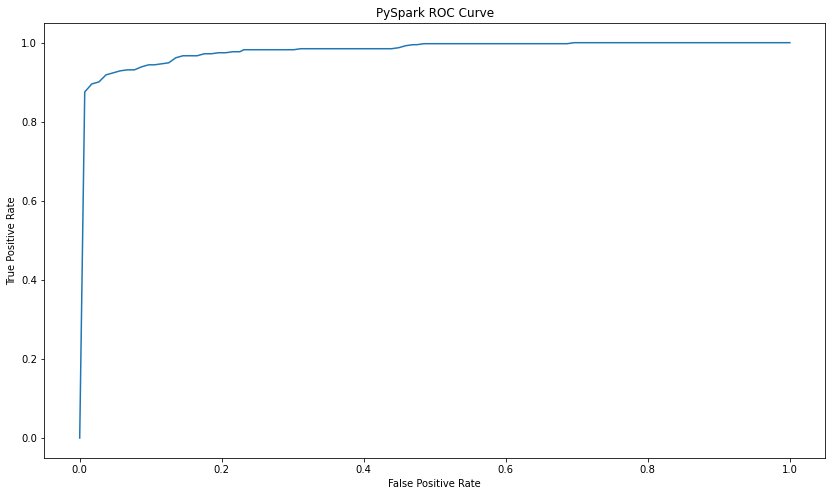

In [9]:
%%time
#Looking at the ROC curve
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])

CPU times: user 3.96 s, sys: 15.1 ms, total: 3.98 s
Wall time: 4 s


Text(0.5, 51.0, 'Predicted')

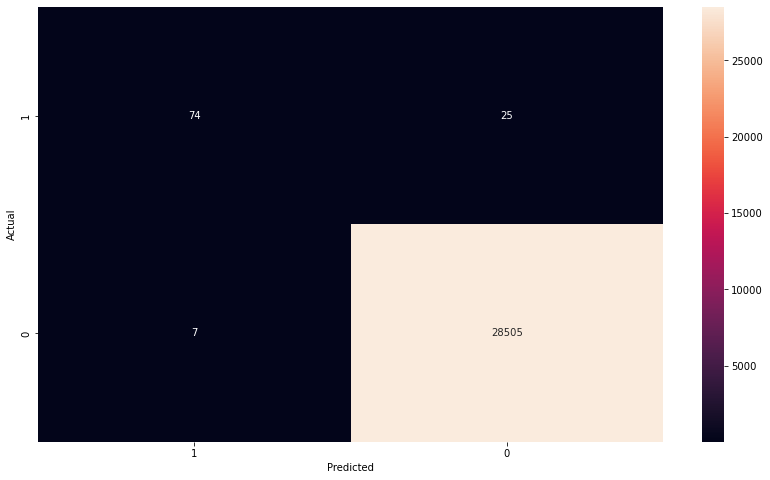

In [10]:
%%time
#confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
#the model has a 74.75 % (74/74+25) accuracy in predicting anomalies

# MLFlow with PySpark

In [11]:
import mlflow
import mlflow.spark
print(mlflow.__version__)

1.30.1


In [12]:
#Defining a function to train the model and calculate some relevant metrics
def train_(spark_model, train_set):
    trained_model = spark_model.fit(train_set)
    trainingSummary = trained_model.summary
    pyspark_auc_score = trainingSummary.areaUnderROC
    mlflow.log_metric("train_acc", trainingSummary.accuracy)
    mlflow.log_metric("train_AUC", pyspark_auc_score)
    print("Training Accuracy: ", trainingSummary.accuracy)
    print("Training AUC:", pyspark_auc_score)

    #Looking at the ROC curve
    pyspark_roc = trainingSummary.roc.toPandas()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('PySpark ROC Curve')
    plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])    
    plt.savefig("pyspark_roc_plot.png")
    plt.clf()
    
    mlflow.log_artifact("pyspark_roc_plot.png")
      
    return trained_model
#function for evaluating the model and calculating some metrics
def evaluate_(spark_model, test_set):
    evaluation_summary = spark_model.evaluate(test_set)
    eval_acc = evaluation_summary.accuracy
    eval_AUC = evaluation_summary.areaUnderROC
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("eval_AUC", eval_AUC)
    print("Evaluation Accuracy: ", eval_acc)
    print("Evaluation AUC: ", eval_AUC)
    
    predictions = spark_model.transform(test_set)
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()  
    
    #confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted') 
    
    plt.title("Confusion Matrix")
    plt.savefig("pyspark_conf_matrix.png")  
    plt.clf()
    
    mlflow.log_artifact("pyspark_conf_matrix.png")

# Building the model and logging into mlflow

In [13]:
%%time
lr = LogisticRegressionPySpark(featuresCol = 'features', labelCol ='label', maxIter=10)

mlflow.set_experiment("PySpark_CreditCard")

with mlflow.start_run():
    trainedLR = train_(lr, train)
    evaluate_(trainedLR, test)
    mlflow.spark.log_model(trainedLR, "creditcard_model_pyspark")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()


Training Accuracy:  0.9986243154435925
Training AUC: 0.9799156765035503


Evaluation Accuracy:  0.9988815490545594
Evaluation AUC:  0.9770529013479351


Model run:  69d50209a88d4cc9b51c7284e2fdacd4
CPU times: user 6.44 s, sys: 421 ms, total: 6.86 s
Wall time: 1min 47s


<Figure size 1008x576 with 0 Axes>

Now we can open the MLFlow UI (mlflow ui -p 1234),
observing the following result

![MLFlow UI](images/mlflow_ui2.png)

# Loading a model saved in mlflow UI

In [14]:
%%time
YOUR_RUN_ID = '69d50209a88d4cc9b51c7284e2fdacd4'
model = mlflow.spark.load_model(f"runs:/{YOUR_RUN_ID}/creditcard_model_pyspark")
type(model)

2023/04/16 00:48:03 INFO mlflow.spark: 'runs:/69d50209a88d4cc9b51c7284e2fdacd4/creditcard_model_pyspark' resolved as 'file:///home/tumbarell/Escritorio/mlflow/MLFlow_with_pyspark/mlruns/1/69d50209a88d4cc9b51c7284e2fdacd4/artifacts/creditcard_model_pyspark'
2023/04/16 00:48:03 INFO mlflow.spark: File 'file:///home/tumbarell/Escritorio/mlflow/MLFlow_with_pyspark/mlruns/1/69d50209a88d4cc9b51c7284e2fdacd4/artifacts/creditcard_model_pyspark/sparkml' is already on DFS, copy is not necessary.


CPU times: user 77.3 ms, sys: 20.7 ms, total: 98.1 ms
Wall time: 1.88 s


pyspark.ml.pipeline.PipelineModel

In [15]:
%%time
from sklearn.metrics import accuracy_score
#making some predictions with the loaded model
predictions = model.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

print(f"AUC Score: {roc_auc_score(y_true, y_pred):.3%}")
print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.3%}")

AUC Score: 87.361%
Accuracy Score: 99.888%
CPU times: user 6.58 s, sys: 18.6 ms, total: 6.59 s
Wall time: 18.7 s


CPU times: user 3.72 s, sys: 2.86 ms, total: 3.72 s
Wall time: 3.72 s


Text(0.5, 51.0, 'Predicted')

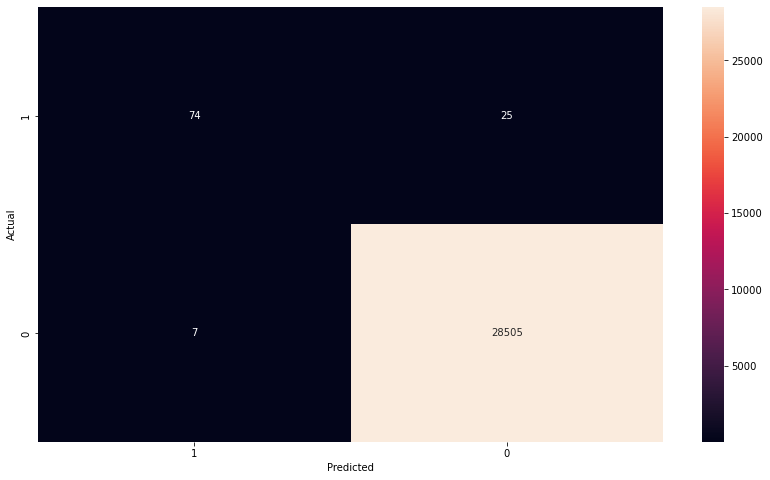

In [16]:
%%time
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')